In [18]:
!ls -al /tf/notebooks/datasets/emotion/multi-modal/part1/KETI_MULTIMODAL_0000000012

total 7632
drwxrwxr-x   3 1005 1000    4096 May  7 01:35 .
drwxrwxr-x 294 1005 1000   12288 May 13 12:31 ..
drwxrwxr-x  12 1005 1000     330 May  7 01:36 KETI_MULTIMODAL_0000000012
-rw-rw-r--   1 1005 1000 6375544 May  7 00:39 KETI_MULTIMODAL_0000000012.mp4
-rw-rw-r--   1 1005 1000  682740 May  7 00:39 KETI_MULTIMODAL_0000000012_interpolation.json
-rw-rw-r--   1 1005 1000    1801 May  7 00:39 KETI_MULTIMODAL_0000000012_jiyu.json
-rw-rw-r--   1 1005 1000    1267 May  7 00:39 KETI_MULTIMODAL_0000000012_jiyu_interpolation.json
-rw-rw-r--   1 1005 1000   38674 May  7 00:39 KETI_MULTIMODAL_0000000012_roykim1234.json
-rw-rw-r--   1 1005 1000  681679 May  7 00:39 KETI_MULTIMODAL_0000000012_roykim1234_interpolation.json


In [28]:
%%bash

source /root/.local/share/jupyter/kernels/rt-face-detect/bin/activate

pip install pycodestyle pycodestyle_magic
pip install flake8

  Using cached https://files.pythonhosted.org/packages/ac/c6/44694103f8c221443ee6b0041f69e2740d89a25641e62fb4f2ee568f2f9c/entrypoints-0.3-py2.py3-none-any.whl


In [29]:
%load_ext pycodestyle_magic

### 공통 전처리 부분 (Frame 단위)

#### inputs:
* 태깅파일: ~_interpolation.json
* 이미지파일: ~KM_0000000000.jpg
* 감정종류: 8가지 ('happiness', 'afraid', 'neutral', 'surprise', 'sadness', 'contempt', 'anger', 'disgust')
    * 예시: {'happiness': 0, 'afraid': 0, 'neutral': 10, 'surprise': 0, 'sadness': 0, 'contempt': 0, 'anger': 0, 'disgust': 0} 일 경우 'neutral'이 선정

In [58]:
import os
import json
import io
import numpy as np
import operator
import collections
import base64
import pandas as pd
from glob import glob
from IPython.display import HTML

# multi-modal 데이터셋 다운로드 위치 입력

# 입력 zip파일의 part 번호
part_num = '4'

# input 폴더
base_folder = '/tf/notebooks/datasets/emotion/multi-modal/part'+part_num+'/'

# output 파일경로
prep_trainset_path='../datasets/kor_multi_modal/prep_part'+part_num+'.csv'

%matplotlib inline

In [59]:
# 태깅설명: http://www.aihub.or.kr/content/555

In [60]:
# 맵핑
def get_tagging_info(json_loaded, img_path_list):
    train_data = []
    for shot_info_idx in range(len(json_loaded["shot_infos"])):
        for visual_info_idx in range(len(json_loaded["shot_infos"][shot_info_idx]["visual_infos"])):
            img_path = json_loaded["shot_infos"][shot_info_idx]["visual_infos"][visual_info_idx]["image_id"]
            if json_loaded["shot_infos"][shot_info_idx]["visual_infos"][visual_info_idx]["persons"] != []:
                for person_info_idx in range(len(json_loaded["shot_infos"][shot_info_idx]["visual_infos"][visual_info_idx]["persons"])):
                    if json_loaded["shot_infos"][shot_info_idx]["visual_infos"][visual_info_idx]["persons"][person_info_idx]["person_info"]["emotion"] != []:
                        person = json_loaded["shot_infos"][shot_info_idx]["visual_infos"][visual_info_idx]["persons"][person_info_idx]
                        face_rect = person['person_info']['face_rect']
                        emotion = person["person_info"]["emotion"]

                        # 수치가 가장 큰 감정 선택
                        max_emo = max(emotion.items(), key=operator.itemgetter(1))[0]
                        
                        img_exist_path = [s for s in img_path_list if img_path in s]
                        if img_exist_path == []:
                            continue
                        
                        full_img_path = img_exist_path[0]
                        
                        if full_img_path != []:
                            train_data.append({'emotion':max_emo, 'img_path':full_img_path, 'face_rect':face_rect})
                                        
            
    return train_data

In [61]:
video_clip_pathes = glob(base_folder+"/*")

raw_tag_info = []

# tmp_idx = 0                      # 작은 데이터로 테스트 필요할 시 주석처리
for video_clip_path in video_clip_pathes:
    
    # 해당 비디오 클립의 전체 이미지 경로
    img_path_list = glob(video_clip_path+"/*/*/*.jpg")    

    # 해당 비디오 클립의 태깅정보 파일 경로
    json_file_name_postfix = video_clip_path.split("_")[-2]+"_"+video_clip_path.split("_")[-1]
    video_clip_tagging_json_path = glob(os.path.join(video_clip_path, "*"+json_file_name_postfix+"_interpolation.json"))

    with open(video_clip_tagging_json_path[0], 'r') as f:
        json_loaded = json.load(f)
        
    raw_tag_info = raw_tag_info + get_tagging_info(json_loaded, img_path_list)
    
#     tmp_idx = tmp_idx + 1  # 작은 데이터로 테스트 필요할 시 주석처리
#     if tmp_idx > 1:              # 작은 데이터로 테스트 필요할 시 주석처리
#         break                       # 작은 데이터로 테스트 필요할 시 주석처리
    
raw_tag_info_df = pd.DataFrame(raw_tag_info)

In [62]:
raw_tag_info_df.head()

,emotion,face_rect,img_path
0,happiness,"{'min_x': 934, 'min_y': 150, 'max_x': 1243, 'm...",/tf/notebooks/datasets/emotion/multi-modal/par...
1,happiness,"{'min_x': 932, 'min_y': 150, 'max_x': 1241, 'm...",/tf/notebooks/datasets/emotion/multi-modal/par...
2,happiness,"{'min_x': 931, 'min_y': 150, 'max_x': 1240, 'm...",/tf/notebooks/datasets/emotion/multi-modal/par...
3,happiness,"{'min_x': 929, 'min_y': 149, 'max_x': 1238, 'm...",/tf/notebooks/datasets/emotion/multi-modal/par...
4,happiness,"{'min_x': 927, 'min_y': 149, 'max_x': 1236, 'm...",/tf/notebooks/datasets/emotion/multi-modal/par...


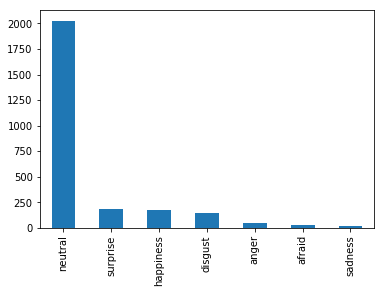

In [63]:
raw_tag_info_df["emotion"].value_counts().plot.bar()

In [64]:
raw_tag_info_df["emotion"].value_counts()

neutral      2026
surprise      190
happiness     179
disgust       143
anger          52
afraid         26
sadness        20
Name: emotion, dtype: int64

In [65]:
# balancing sampling

## disgust와 contempt는 disgust 하나로 합침
# raw_tag_info_df[raw_tag_info_df["emotions"]=='contempt'] = 'disgust'
raw_tag_info_df = raw_tag_info_df.replace('contempt', 'disgust')


min_emotion_cnt = np.min(raw_tag_info_df["emotion"].value_counts())
sampled_tag_info_df = raw_tag_info_df.groupby("emotion", group_keys=False).apply(lambda df: df.sample(min_emotion_cnt))
sampled_tag_info_df = sampled_tag_info_df.reset_index(drop=True)

In [66]:
sampled_tag_info_df["emotion"].value_counts()

anger        20
afraid       20
neutral      20
disgust      20
sadness      20
happiness    20
surprise     20
Name: emotion, dtype: int64

In [68]:
sampled_tag_info_df.count()

emotion      140
face_rect    140
img_path     140
dtype: int64

### Real-time Convolutional Neural Networks for Emotion and Gender Classification 모델을 위한 전처리 부분

In [69]:
import cv2
import re
import numpy as np
import matplotlib.pyplot as plt
from multiprocessing import Pool

In [70]:
import multiprocessing

# num_cores = multiprocessing.cpu_count()
num_cores = 5

In [71]:
def img_path_to_pixel(x):
    
    img_path, face_rect = x[0], x[1]
    
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    img_shape = img.shape
    
    # face_rect 부분 잘라내기
    # ex) 'max_x': 1125, 'max_y': 798, 'min_x': 708, 'min_y': 267
    min_x = face_rect['min_x']
    max_x = face_rect['max_x']
    min_y = face_rect['min_y']
    max_y = face_rect['max_y']
    
    if  not isinstance(min_x, int) or not isinstance(max_x, int) or  not isinstance(min_y, int) or not isinstance(max_y, int) or \
        min_x <= 0 or max_x <= 0 or min_y <= 0 or max_y <= 0:
        return None
    
#     print(min_y,max_y, min_x,max_x)
    img = img[min_y:max_y, min_x:max_x]
    
    # 이미지 축소 시에는 INTER_AREA, https://076923.github.io/posts/Python-opencv-8/
    img = cv2.resize(img, dsize=(48, 48), interpolation=cv2.INTER_AREA)
    
    # split array to ' ' str
    img = ' '.join(img.astype(int).astype(str).reshape(-1))
    
    return img

In [72]:
def multi_process_sub(df_split):

    return df_split[['img_path', 'face_rect']].apply(img_path_to_pixel, axis=1)

In [73]:
def multi_process(df, func):
    df_split = np.array_split(df, num_cores)
    pool = Pool(num_cores)
    df = pd.concat(pool.map(func, df_split))
    pool.close()
    pool.join()
    return df

In [74]:
# %time sampled_tag_info_df['img_path_new'] = sampled_tag_info_df[['img_path','face_rect']].apply(img_path_to_pixel, axis=1)

In [75]:
%time sampled_tag_info_df['img_path_new'] = multi_process(sampled_tag_info_df, multi_process_sub)

CPU times: user 45.4 ms, sys: 373 ms, total: 419 ms
Wall time: 894 ms


In [76]:
# 이상 데이터 drop
sampled_tag_info_df = sampled_tag_info_df.dropna().reset_index(drop=True)

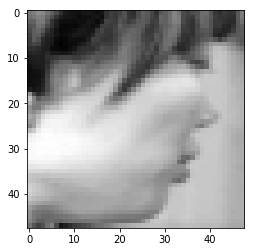

In [91]:
plt.imshow(np.asarray(sampled_tag_info_df.loc[0]['img_path_new'].split(' ')).astype(int).reshape((48,48)), 'gray')

In [78]:
sampled_tag_info_df['img_path'] = sampled_tag_info_df['img_path_new']
prep_tag_info_df = sampled_tag_info_df.drop(['img_path_new', 'face_rect'], axis=1)

In [79]:
prep_tag_info_df.head()

,emotion,img_path
0,afraid,85 89 98 96 83 73 59 43 30 26 25 24 28 29 26 2...
1,afraid,89 88 84 86 84 75 51 45 34 35 38 40 38 31 32 5...
2,afraid,72 70 78 74 73 61 45 42 37 37 36 38 45 73 57 4...
3,afraid,72 70 68 76 77 76 58 48 47 44 36 29 42 72 49 3...
4,afraid,77 80 81 71 54 47 43 40 35 34 51 79 48 44 50 5...


## 전처리 step 2

* CSV dataset file 생성
    * 포멧: emotion
    * emotion mapping
        * ASIS: 8 Catogory ('happiness', 'afraid', 'neutral', 'surprise', 'sadness', 'contempt', 'anger', 'disgust')
        * TO: 7 Category  (0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral)
        * mapped Category: 0=anger, 1=disgust&contempt, 2=afraid, 3=happiness, 4=sadness, 5=surprise, 6=neutral

In [80]:
def emotion_mapping(emotion):
    if emotion == 'anger':
        return 0
    elif emotion == 'disgust' or emotion == 'contempt':
        return 1
    elif emotion == 'afraid':
        return 2
    elif emotion == 'happiness':
        return 3
    elif emotion == 'sadness':
        return 4
    elif emotion == 'surprise':
        return 5
    elif emotion == 'neutral':
        return 6
    else:
        return 6
        

prep_tag_info_df['mapped_emotion'] = prep_tag_info_df['emotion'].map(emotion_mapping)

In [81]:
prep_tag_info_df['mapped_emotion'].value_counts()

5    20
3    20
2    20
0    20
6    19
4    15
1    15
Name: mapped_emotion, dtype: int64

In [82]:
prep_tag_info_df['emotion'] = prep_tag_info_df['mapped_emotion']
prep_tag_info_df = prep_tag_info_df.drop(['mapped_emotion'], axis=1)
prep_tag_info_df.head()

,emotion,img_path
0,2,85 89 98 96 83 73 59 43 30 26 25 24 28 29 26 2...
1,2,89 88 84 86 84 75 51 45 34 35 38 40 38 31 32 5...
2,2,72 70 78 74 73 61 45 42 37 37 36 38 45 73 57 4...
3,2,72 70 68 76 77 76 58 48 47 44 36 29 42 72 49 3...
4,2,77 80 81 71 54 47 43 40 35 34 51 79 48 44 50 5...


In [ ]:
!ls -alh ../datasets/kor_multi_modal/

In [ ]:
prep_tag_info_df.to_csv(prep_trainset_path, index=False)

In [ ]:
tmp_df = pd.read_csv(prep_trainset_path)

In [ ]:
tmp_df.head()

In [90]:
!ls -alh ../datasets/kor_multi_modal/

total 1.9G
drwxr-xr-x 3 root root  157 Jul  6 19:15 .
drwxr-xr-x 4 root root  104 Jun 30 09:50 ..
drwxr-xr-x 2 root root  12K Jun 30 09:50 part1
-rw-r--r-- 1 root root 240M Jul  6 18:18 prep_part1.csv
-rw-r--r-- 1 root root 415M Jul  6 18:31 prep_part2.csv
-rw-r--r-- 1 root root 464M Jul  6 18:38 prep_part3.csv
-rw-r--r-- 1 root root 476M Jul  6 18:42 prep_part4.csv
-rw-r--r-- 1 root root 267M Jul  6 19:15 prep_part5.csv
